In [1]:
#Loading Libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Dropout, Concatenate, Input , Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from patchify import patchify, unpatchify

In [2]:
# Defining function to extract images from traget folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = img.resize((256,256))
            img = img.convert('RGB')
            img = np.array(img)
            images.append(img)
    
    images = np.array(images)
    images = images/255
    return images

In [3]:
#Location of image folder
folder_1 = r"C:\Users\Hp\Downloads\Train\low"
folder_2 = r"C:\Users\Hp\Downloads\Train\high"

In [4]:
# x-->Low and noisy images
# y-->High and non-noisy target images
x = load_images_from_folder(folder_1)
y = load_images_from_folder(folder_2)

In [5]:
# Creating more data images by making patches
# In this code each image is divided into 16 images
patch_size = 64

x_patches = np.vstack([patchify(img, (patch_size, patch_size, 3), step=patch_size) for img in x])
y_patches = np.vstack([patchify(mask, (patch_size, patch_size, 3), step=patch_size) for mask in y])

x_patches = x_patches.reshape(-1, patch_size, patch_size, 3)
y_patches = y_patches.reshape(-1, patch_size, patch_size, 3)

In [6]:
# Building class for model building with required functions
class ChannelAttention(Layer):
    def __init__(self, filters, ratio=16):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.fc1 = layers.Conv2D(filters // ratio, 1, activation='relu', padding='same')
        self.fc2 = layers.Conv2D(filters, 1, padding='same')

    def call(self, x):
        avg_out = self.fc2(self.fc1(tf.expand_dims(tf.expand_dims(self.avg_pool(x), 1), 1)))
        max_out = self.fc2(self.fc1(tf.expand_dims(tf.expand_dims(self.max_pool(x), 1), 1)))
        return x * tf.sigmoid(avg_out + max_out)

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(1, kernel_size, activation='sigmoid', padding='same')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        return x * self.conv(tf.concat([avg_out, max_out], axis=-1))

def conv_block(x, filters, kernel_size, strides, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def residual_block(x, filters):
    shortcut = x
    x = conv_block(x, filters, 3, 1, activation='relu')
    x = conv_block(x, filters, 3, 1, activation=None)
    x = ChannelAttention(filters)(x)
    x = SpatialAttention()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [7]:
# Model Building
def model_building(input_shape=(None, None, 3), num_residual_blocks=10):
    inputs = layers.Input(shape=input_shape)
    x = conv_block(inputs, 64, 3, 1, activation='relu')
    
    for _ in range(num_residual_blocks):
        x = residual_block(x, 64)
    
    x = conv_block(x, 64, 3, 1, activation='relu')
    x = layers.Conv2D(3, 3, strides=1, padding='same')(x)
    
    outputs = layers.Add()([x, inputs])
    model = models.Model(inputs, outputs)
    return model

In [8]:
# Defining model, optimizers and loss.
model = model_building()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss=losses.MeanSquaredError())

In [9]:
# Variable learning rate and early stopping
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
]

In [14]:
# Training the data to the model
model.fit(x_patches,y_patches, epochs=30, callbacks=callbacks,batch_size=16, validation_split=0.1)

Epoch 1/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 247s 566ms/step - loss: 0.0333 - val_loss: 0.0211 - learning_rate: 1.0000e-04
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 237s 543ms/step - loss: 0.0210 - val_loss: 0.0203 - learning_rate: 1.0000e-04
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 231s 528ms/step - loss: 0.0191 - val_loss: 0.0200 - learning_rate: 1.0000e-04
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 246s 564ms/step - loss: 0.0183 - val_loss: 0.0184 - learning_rate: 1.0000e-04
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 234s 536ms/step - loss: 0.0179 - val_loss: 0.0191 - learning_rate: 1.0000e-04
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 248s 567ms/step - loss: 0.0175 - val_loss: 0.0194 - learning_rate: 1.0000e-04
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 242s 553ms/step - loss: 0.0175 - val_loss: 0.0182 - learning_rate: 1.0000e-04
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 249s 569ms/step - loss: 0.0170 - val_loss: 0.0181 - learning_rate: 1.0000e-04
Epoch 9/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 246s 564ms/step 

In [15]:
# Prediction 
x_denoised = model.predict(x)

16/16 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step


In [40]:
# Define function for psnr
def psnr(target, ref):
    target_data = np.array(target, dtype=np.float32)
    ref_data = np.array(ref, dtype=np.float32)
    diff = ref_data - target_data
    rmse = np.sqrt(np.mean(diff ** 2))
    psnr_value = 20 * np.log10(1.0 / rmse)
    return psnr_value

In [41]:
# Calculate PSNR for x
psnr_values = [psnr(y[i], x[i]) for i in range(len(y))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

Average PSNR: 7.765406973920432


In [42]:
# Calculate PSNR for x_denoised
psnr_values = [psnr(y[i], x_denoised[i]) for i in range(len(y))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

Average PSNR: 20.912801964193243


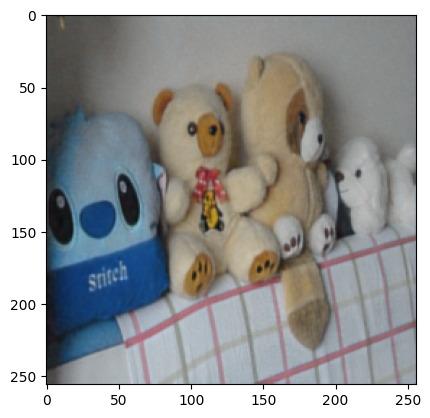

In [18]:
# Image obtained by first denoising model
plt.imshow(x_denoised[0])
plt.show()

In [25]:
# Creating more data images by making patches
# In this code each image is divided into 64 images
patch_size_2 = 32
x_denoised_patches = np.vstack([patchify(img, (patch_size_2, patch_size_2, 3), step=patch_size_2) for img in x_denoised])
x_denoised_patches = x_denoised_patches.reshape(-1, patch_size_2, patch_size_2, 3)
y_patches_2 = np.vstack([patchify(mask, (patch_size_2, patch_size_2, 3), step=patch_size_2) for mask in y])
y_patches_2 = y_patches_2.reshape(-1, patch_size_2, patch_size_2, 3)

In [26]:
# Passing the x_denoised again in the same moel with new features and optimizers
# Defining the new model
model_2 = model_building()
model_2.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=losses.MeanSquaredError())

In [27]:
model_2.fit(x_denoised_patches,y_patches_2, epochs=30, callbacks=callbacks,batch_size=16, validation_split=0.1)

Epoch 1/30
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 269s 151ms/step - loss: 0.0112 - val_loss: 0.0150 - learning_rate: 1.0000e-04
Epoch 2/30
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 264s 151ms/step - loss: 0.0101 - val_loss: 0.0138 - learning_rate: 1.0000e-04
Epoch 3/30
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 260s 149ms/step - loss: 0.0100 - val_loss: 0.0136 - learning_rate: 1.0000e-04
Epoch 4/30
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 257s 147ms/step - loss: 0.0097 - val_loss: 0.0142 - learning_rate: 1.0000e-04
Epoch 5/30
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 257s 147ms/step - loss: 0.0098 - val_loss: 0.0136 - learning_rate: 1.0000e-04
Epoch 6/30
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 260s 149ms/step - loss: 0.0097 - val_loss: 0.0130 - learning_rate: 1.0000e-04
Epoch 7/30
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 263s 150ms/step - loss: 0.0096 - val_loss: 0.0134 - learning_rate: 1.0000e-04
Epoch 8/30
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 262s 150ms/step - loss: 0.0095 - val_loss: 0.0133 - learning_rate: 1.0000e-04
Epoch 9/30
1746/1746 ━━━━━━━━━━━━━━━━━━━

In [28]:
x_denoised_2 = model_2.predict(x_denoised)

16/16 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step


In [29]:
# Calculating psnr for final denoised image i.e. x_denoised_2
psnr_values = [psnr(y[i], x_denoised_2[i]) for i in range(len(y))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

Average PSNR: 23.45090133887874


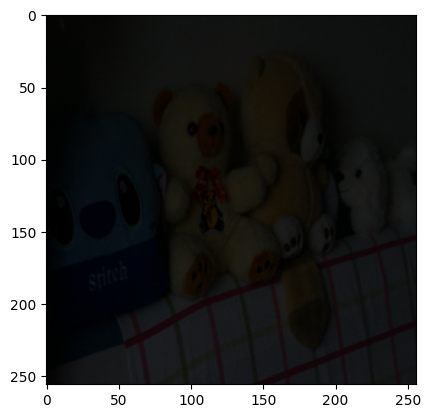

In [32]:
# Original images
plt.imshow(x[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


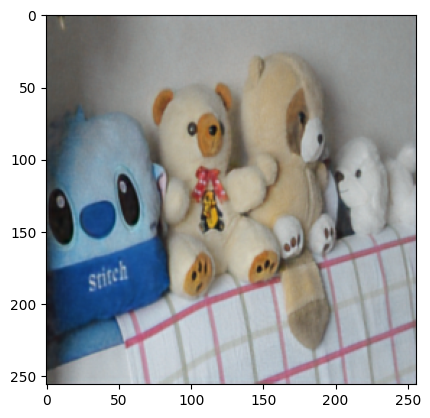

In [30]:
# Final denoised images
plt.imshow(x_denoised_2[0])
plt.show()

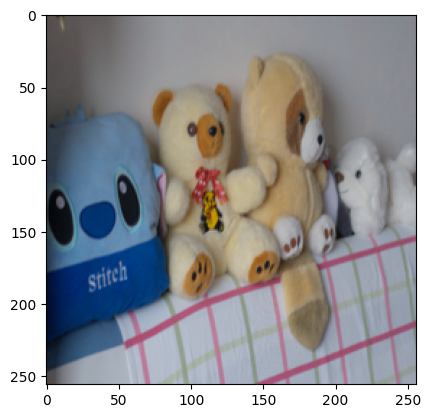

In [31]:
# Target images 
plt.imshow(y[0])
plt.show()

`FINAL PSNR OBTAINED IS ROUGHLY AROUNG 23.451`

`For usnig model for testing -->`\
x = model(input)\
x_denoised_final = model_2(x)

In [ ]:
def load_model_and_predict():
    # Loading models
    model_1 = tf.keras.models.load_model('model_1.keras')
    model_2 = tf.keras.models.load_model('model_2.keras')

    # Input and Output locations
    input_dir = './test/low/'
    output_dir = './test/predicted/'

    img_array = load_images_from_folder(input_dir)

    # Predicting
    x = model_1.predict(img_array)
    prediction = model_2.predict(x)

    # Saving outputs to output_dir
    for i, prediction in enumerate(prediction):
        predicted_img = Image.fromarray((prediction * 255).astype(np.uint8))
        predicted_img.save(os.path.join(output_dir,i))

In [ ]:
load_model_and_predict()

For calculating PSNR I have already defined a function named `def_psnr()`